In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import ipywidgets

# Kalman filter


- Filtro lineal Gaussiano de Markov
- Filtro paramétrico: $\mu$, $\sigma^2$, la gaussiana esta totalmente definida por su media y su varianza
- Unimodal
- Google lo usa para mejor la precisión en la localización del auto

**Ventaja:**

En vez de lidiar con el histograma completo solo lideamos con los parámetros

**Desventaja:**

Asumir distribuciones Gaussianas (multimodal) puede no ser un buen modelo (ejemplo de puertas)

# El modelo (Objeto en movimiento)
## Definición

$S_{n+1} = aS_{n} + U_n + W_n$

$X_n = S_n + V_n$

Similar al [filtro de histograma con ruido aditivo](https://github.com/jganzabal/Kalman-as-Recursive-Bayesian-Estimation/blob/master/Additive%20noise%20Histogram%20Filters.ipynb) pero con algunas diferencias fundamentales:
- $S_n$ es un proceso continuo. No tenemos más estados discretos
- $W_n$ es Gaussiana con media cero
- $V_n$ es Gaussiana con media cero

## Cambio de notación
Desafortunadamente la convención para notación usada en filtros de Kalman difiere de la utilizada por los HMM y los filtros de histogramas

Para estar en consonancia con la bibliografía actual cambiaremos la notación

$(1)\quad X_{n+1} = aX_n + b_nU_n + W_n$

$(2) \quad Z_n = hX_n + V_n \quad \quad \quad$

**$X$**: El Estado. En nuestro ejemplo es la posición del robot.  - Antes $S$

**$Z$**: La observación. - Antes $X$

**$W$**: El ruido del proceso. Para el robot caminando, alta varianza de $W$ indica que el robot no es muy preciso cuando camina

**$a$**: El faltor de la trancisión de estado. En nuestro ejemplo es 1. Si es mayor a uno se podría pensar que el robot esta acelerando exponencialmente. Va a tener más sentido con el filtro de Kalman vectorial que se discutira en la proxima sección.

**$b_n$, $U_n$**: La entrada de control del modelo. Va a tener más sentido con el filtro de Kalman vectorial que se discutira en la proxima sección. Va a ser 1 para nuestro robot que camina.

**$h$**: Modelo de observación. Mapeo el estado verdadero en el espacio de observación

**$V_n$**: Ruido de observación

# Modelo generativo

In [7]:
def generate_sample_(X_o = 0, sigma_w = 0.1,sigma_v = 0.1, h = 1, a = 1, b = 1, U = 1, steps = 10):
    # Call the package function. This is just an example
    # X_o: Initial position
    # sigma_w: Variance of W
    # sigma_v: Variance of V
    # First I am in state X_o. Remeber that X is S in our old model
    # So our first measurement is based on equation (2)
    real_positions = [X_o]
    measurements = [h*X_o + np.random.normal(0,sigma_v)]
    X_k = X_o
    for i in range(steps):
        # This is equation (1)
        X_k = a*X_k + b*U + np.random.normal(0,sigma_w)
        real_positions.append(X_k)
        # This is equation (2)
        Z = h*X_k + np.random.normal(0,sigma_v)
        measurements.append(Z)
    return measurements, real_positions

Grafiquemos como se ve el proceso para algunos casos:

## Ruido de observación mucho mayor al ruido del proceso : $\sigma_w^2 << \sigma_v^2$
Mucho error de observación pero caminata regular ('smothly')

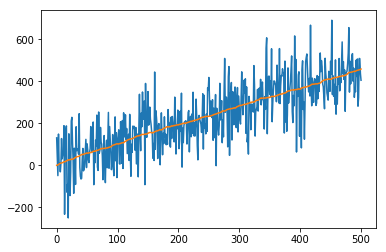

In [8]:
from kalman1d import generate_sample
measurements, real_positions = generate_sample(X_o = 0, sigma_w = 1,
                                               sigma_v = 100, 
                                               h = 1, a = 1, b = 1, U = 1, 
                                               steps = 500)
plt.plot(measurements)
plt.plot(real_positions)
plt.show()

## Ruido del proceso mucho mayor que el de medición: $\sigma_w^2 >> \sigma_v^2$
Mucho error al caminar: Caminata no uniforme

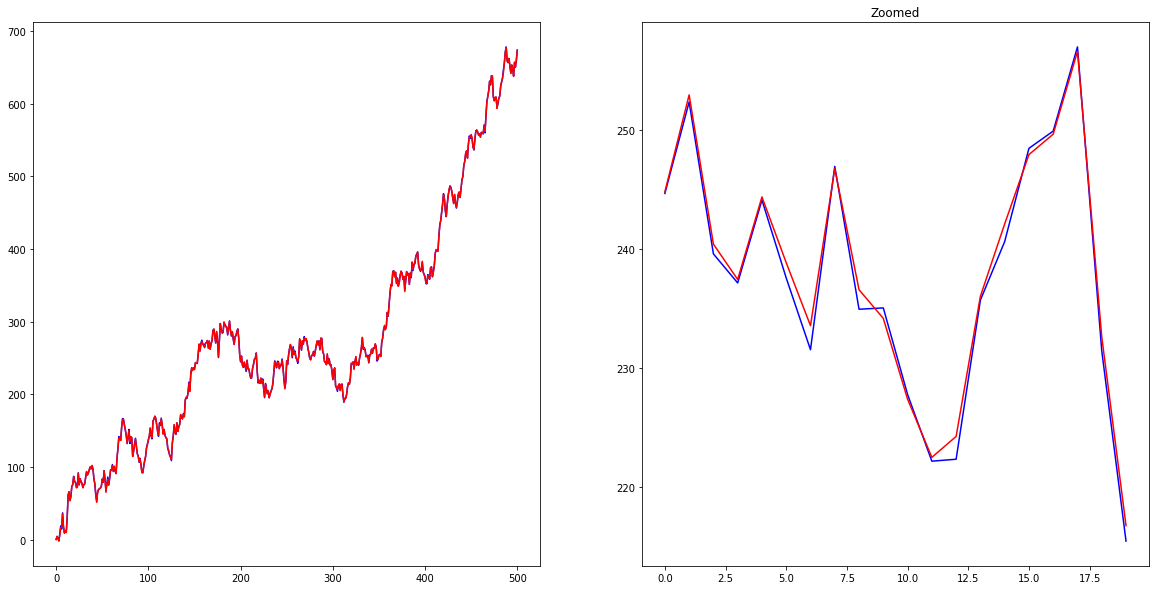

In [9]:
measurements, real_positions = generate_sample(X_o = 0, 
                                               sigma_w = 10,
                                               sigma_v = 1, 
                                               h = 1, a = 1, b = 1, U = 1, steps = 500)
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.plot(measurements, 'b')
plt.plot(real_positions, 'r')
plt.subplot(1,2,2)
plt.plot(measurements[200:220], 'b')
plt.plot(real_positions[200:220], 'r')
plt.title('Zoomed')
plt.show()

# El modelo

En vez de tener probabilidades tenemos densidades de probabilidad. Minuscula $p$ para la densidad y mayúscula $P$ para la probabilidad

**Ruido del proceso** (W) - Ruido del movimiento en nuestro ejemplo:

$p(W) = N(0,\sigma_w^2) = \Large{\frac{1}{\sigma_w \sqrt{2\pi}} e^{-\frac{1}{2}\frac{(W)}{\sigma_w^2}^2}}$

$\mu_w = 0$

**Ruido de observación / Error de medición**:

$p(V) = N(0,\sigma_v^2) = \Large{\frac{1}{\sigma_v \sqrt{2\pi}} e^{-\frac{1}{2}\frac{(V)}{\sigma_v^2}^2}}$

$\mu_v = 0$

## La densidad en la observación - $Z_n = h X_n + V$
Es la densidad antes de observar, dado que estamos en el estado $X_n$

V es Gaussiana con media 0, entonces $Z_n$ dado que estamos en el estado $X_n$ va a ser Gaussiana con media $h X_n$. 

$E\{Z_n\} = E\{h X_n + V\} = h E\{X_n\} + E\{V\} = hX_n$

Como lo unico aleatorio es $V$, las varianzas son iguales  
$\sigma_z^2 = \sigma_v^2$

$p(Z_n|X_n) = N(h X_n,\sigma_v^2) = \Large{\frac{1}{\sigma_v \sqrt{2\pi}} e^{-\frac{1}{2}\frac{(Z_n-h X_n)}{\sigma_v^2}^2}}$


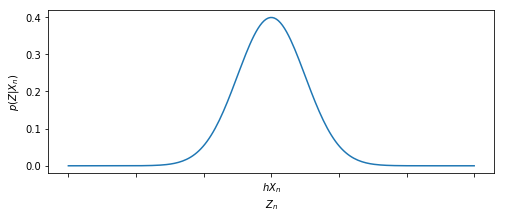

In [10]:
from kalman1d import plot_gaussian
_ = plot_gaussian(N = 6, y_label = "$p(Z|X_n)$", x_label = "$Z_n$", center_label_tick = "$hX_n$",figsize=(8,3))

Es este el likelihood?

## El likelihood -  $\mathcal{L}(X_n)$ = $p(Z_n|X_n)$ 

Recoradar que para el likelihood, la observación $Z_n$ esta fija y $X_n$ es lo que varía

$p(Z=Z_n|X_n) = N(h X_n,\sigma_v^2) = 
\large{\frac{1}{\sigma_v \sqrt{2\pi}} e^{-\frac{1}{2}\frac{(Z_n-h X_n)}{\sigma_v^2}^2}} = 
\large{\frac{1}{\sigma_v \sqrt{2\pi}} e^{-\frac{1}{2}\frac{(h\frac{Z_n}{h}-h X_n)}{\sigma_v^2}^2}} = 
\large{\frac{1}{\sigma_v \sqrt{2\pi}} e^{-\frac{1}{2}\frac{(\frac{Z_n}{h}-X_n)}{\frac{\sigma_v^2}{h^2}}^2}} =
\alpha N(\frac{Z_n}{h},\frac{\sigma_v^2}{h^2})$

Esto es equivalente a una Gaussiana que depende de $X_k$ con media $\frac{Z}{h}$  y varianza $\frac{\sigma_v^2}{h^2}$

Si h = 1, la distribución del likelihood es la misma que la distribución de la observación

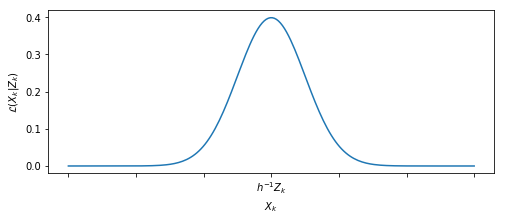

In [11]:
_ =plot_gaussian(N = 6, y_label = "$\mathcal{L}(X_k|Z_k)$", x_label = "$X_k$", 
                 center_label_tick = "$h^{-1}Z_k$",figsize=(8,3))

## A Priori (belief): Antes de medir

$p(X_n) = N(\hat{x}_{n}, p_{0}) = \Large{\frac{1}{\sqrt{2\pi p_{0}}} e^{-\frac{1}{2}\frac{(X_n-\hat{x}_{0})}{p_{0}}^2}}$

Al comenzar, $p_{0}$ incerteza inicial (La varianza). Usualmente mayor que $\sigma_w^2$ y $\sigma_v^2$.

$\hat{x}_{0}$ usualmente cero (Initial guess)

## A Posteriori: Probabilidad del luego de medir


$\large{p(X_n|Z_n) = \alpha p(Z_n|X_n)p(X_n)}$

**Bayes**:

$\large{p(X_n|Z_n) = \frac{p(Z_n|X_n)p(X_n)}{p(Z_n)}}$

$p(Z_n) = \int_{-\infty}^{\infty} {p(Z_n|X = x)p(x)} dx$

Como la a priori y el likelihood son gaussianas la a posteriori es Gaussiana tambien

# El filtro
## La meta.
Estimatar mi posición $X_n$ dadas las observaciones $Z_1, ..., Z_n$
## Update - Bayes
Dadas las probabilidades a priori y el likelihood, Encontrar la a posteriori $X_n$

$Z_n = h X_n + V$

## Predicción - Suma de variables aleatorias - Convolución

$X_{n+1} = aX_{n} + bU_n + W$

## Loop
Mi predicción es mi a priori, entonces observo otra vez X, hago update, y asi ...

# Update - Bayes

## Producto de las densidades de probabilidad Gaussianas

https://github.com/jganzabal/Kalman-as-Recursive-Bayesian-Estimation/blob/master/pdfs/gaussians_convolutions_lecture3.pdf

El producto 2 pdfs Gaussianas con parámetros $\mu_u$, $\sigma_u^2$ y  $\mu_{v}$,$\sigma_{v}^2$ es proporcional a una Gaussiana con parámetros $\mu_{x}$,$\sigma_{x}^2$ calculados de la siguiente forma

$p(X) = \alpha p(U)p(V)$

$\mu_{x} = \Large{\frac{\sigma_u^2\mu_v +\mu_u \sigma_v^2}{\sigma_u^2 + \sigma_v^2}}$

Resistencias en paralelo (analogía)

$\sigma_{x}^2 = \Large{\frac{\sigma_u^2 \sigma_v^2}{\sigma_u^2 + \sigma_v^2}}$


### Implementación

In [12]:
def gauss_pdf_mult(mean1, var1, mean2, var2):
    new_mean = float(var2 * mean1 + var1 * mean2) / (var1 + var2)
    new_var = 1./(1./var1 + 1./var2)
    return [new_mean, new_var]

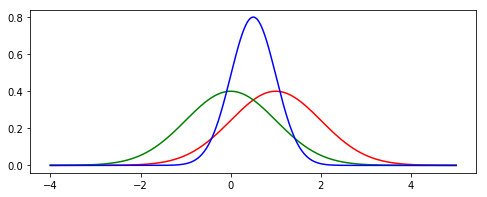

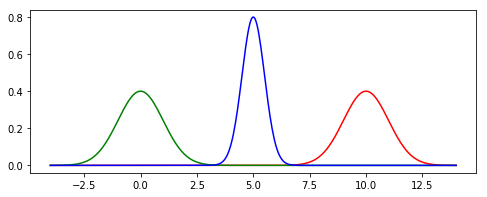

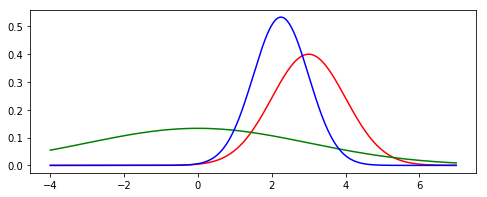

In [13]:
def plot_product(mu_u, sig_u, mu_v, sig_v, points=400):
    f, ax = plt.subplots(1, 1, sharey=True, sharex=True, figsize = (8,3))
    N = 4
    x = np.linspace(min(mu_u,mu_v)-N*sig_u, max(mu_u,mu_v)+N*sig_u, points)
    
    _, prior =plot_gaussian(mu = mu_u, sig = sig_u, N = 6, ax = ax, x=x, color = 'r')
    _, likelihood =plot_gaussian(mu = mu_v, sig = sig_v, ax = ax, x=x, color = 'g')

    mu_y, sig_y = gauss_pdf_mult(mu_u, sig_u, mu_v, sig_v)

    _ = plot_gaussian(mu = mu_y, sig = sig_y, N = 6, ax = ax, x=x, color = 'b')
    plt.show()
    
sig_u = 1; sig_v = 1; mu_u = 1; mu_v = 0
plot_product(mu_u, sig_u, mu_v, sig_v)
sig_u = 1; sig_v = 1; mu_u = 10; mu_v = 0
plot_product(mu_u, sig_u, mu_v, sig_v)
sig_u = 1; sig_v = 3; mu_u = 3; mu_v = 0
plot_product(mu_u, sig_u, mu_v, sig_v)

La azul es el resultado del producto de la roja por la verde.  
Tener en cuenta que la azul esta normalizada luego de multiplicar (El denominador en la regla de Bayes)

### Conclusiones:
- La varianza del producto de 2 pdfs Gaussianas es siempre menos que el minimo entre ambas (Resistencias en paralelo)
- Difernciar el producto entre ambas PDFs y el producto de las dos V.A
- El update siempre aumenta la certeza (disminuye la incerteza)

## Apliquemosla al modelo

$\large{p(X_n|Z_n) = \alpha p(Z_n|X_n)p(X_n)}$

Observamos $Z$ y obtenemos el likelihood $N(h^{-1}Z,\sigma_v^2h^{-2})$. Recordar que h y $\sigma_v^2$ son conocidas

$(1)\quad\large{N(\hat{X}_{n|n}, p_{n|n})  = \alpha N(h^{-1}Z,\sigma_v^2h^{-2})N(\hat{X}_{n|n-1}, p_{n|n-1})}$

Aclaración en la notación:

$\hat{X}_{n|n-1}$: Es la estimación de la posición en el paso previo. Para el primer paso $X_0$

$p_{n|n-1}$: La incertidumbre en la estimación de la posición en el paso previo. Para el primer paso $p_0$

$\hat{X}_{n|n}$: La estimación de la posición en el paso n dado que ya tenemos la n-esima observación

$p_{n|n}$: La incertidumbre de la estimación de la posición dado que tenemos la n-esima observación

**Propiedades del producto de las PDFs de Gaussianas **

$(2)\quad \sigma_x^2 = ({\sigma_a^2}^{-1} + {\sigma_b^2}^{-1})^{-1}$

$(3)\quad \mu_x = \frac{\sigma_x^2 }{\sigma_a^2}\mu_a + \frac{\sigma_x^2}{\sigma_b^2}\mu_b = 
\sigma_x^2[\frac{\mu_a }{\sigma_a^2} + \frac{\mu_b}{\sigma_b^2}] $

**Identifiquemos cada parámetro**

Ecuación (1) con (3)

$\sigma_x^2 = p_{n|n} \quad \sigma_a^2 = \frac{\sigma_v^2}{h^2} \quad \sigma_b^2 = p_{n|n-1}\quad$

Ecuación (1) con (2)

$\mu_x = \hat{X}_{n|n} \quad \mu_a = h^{-1}Z \quad \mu_b = \hat{X}_{n|n-1}$

**Reemplazando y simplificando**

$\hat{X}_{n|n} = p_{n|n}[\frac{hZ}{\sigma_v^2} +  \frac{\hat{X}_{n|n-1}}{p_{n|n-1}}]$

$p_{n|n} = \Large{\frac{p_{n|n-1} \sigma_v^2}{p_{n|n-1}h^{2} + \sigma_v^2}}$

## La implementación

In [14]:
def update(h, sigma_v, Z, X_est_prior, P_prior):
    P = P_prior*sigma_v/(P_prior*(h**2) + sigma_v)
    X_est = P*(h*Z/sigma_v + X_est_prior/P_prior)
    return X_est, P

## Ganancia de Kalman

$K = \frac{p_{n|n-1}{h}}{p_{n|n-1}h^{2} + \sigma_v^2} \quad 1 - hK = \frac{p_{n|n-1}{\sigma_v^2}}{p_{n|n-1}h^{2} + \sigma_v^2}$

$\hat{X}_{n|n} = p_{n|n}[\frac{hZ}{\sigma_v^2} +  \frac{\hat{X}_{n|n-1}}{p_{n|n-1}}] = 
\hat{X}_{n|n-1} + K(Z-h\hat{X}_{n|n-1})$

$p_{n|n} = \Large{\frac{p_{n|n-1} \sigma_v^2}{p_{n|n-1}h^{2} + \sigma_v^2}} = p_{n|n-1}(1-hK)$

Observaciones:  
Dos situaciones posibles para que $1 - hK$ (recordar que en nuestro ejemplo h es 1) tienda a 0, lo que es equivalente a que la incerteza en la estimación luego de la observación tienda a 0  
- $\sigma_v^2$ tiene que tender a 0 (No hay ruido en la observación)
- Si la incertudumbre antes de la observación es muy baja

In [15]:
def update_with_kalman_gain(h, sigma_v, Z, X_est_prior, P_prior):
    K = P_prior*h/(P_prior*h**2+sigma_v)
    P = P_prior*(1-h*K)
    X_est = X_est_prior + K*(Z-h*X_est_prior)
    return X_est, P, K

# Predicción - Convolución de las PDFs Gaussianas

La suma de variables aleatorieas Gaussianas es una Gaussiana donde la media y la varianza de la nueva Gaussiana es la suma de las medias y varianzas de los sumandos

$X = U + V$

$\mu_{X} = \mu_{U} +\mu_V$

$\sigma_{X}^2 = \sigma_{U}^2 +\sigma_V^2$

## Implementación

In [16]:
def gauss_var_add(mean1, var1, mean2, var2):
    new_mean = mean1 + mean2
    new_var = var1 + var2
    return [new_mean, new_var]

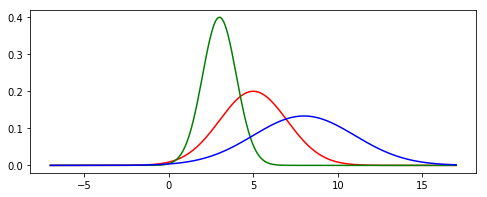

In [17]:
f, ax = plt.subplots(1, 1, sharey=True, sharex=True, figsize = (8,3))
mu_s = 5
sig_s = 2
mu_w = 3
sig_w = 1
x, posterior = plot_gaussian(mu = mu_s, sig = sig_s, N = 6, ax = ax, color = 'r')
W = plot_gaussian(mu = mu_w, sig = sig_w, N = 6, ax = ax, x=x, color = 'g')

mu_p, sig_p = gauss_var_add(mu_s,sig_s, mu_w,sig_w)

W = plot_gaussian(mu = mu_p, sig = sig_p, N = 6, ax = ax, x=x, color = 'b')
plt.show()

La azul es el resultado de la convolución entre la roja y la verde

### Aplicado al modelo:

**Equación del modelo**

$X_{n|n-1} = aX_{n|n} + bU_{n} + W$


** Reemplazando**

$\mu_W = 0$

$\hat{X}_{n|n-1} = a\hat{X}_{n|n} +\mu_w + bU_k = a\hat{X}_{n|n} + bU_n$

$p_{n|n-1} = a^2p_{n|n} +\sigma_w^2$

Ahora etapa de Update

In [18]:
def predict(sigma_w, X_updated, P_updated, a = 1, b = 1, U = 1):
    X_predicted = a*X_updated + b*U
    P_predicted = (a**2)*sigma_w + P_updated
    return X_predicted, P_predicted

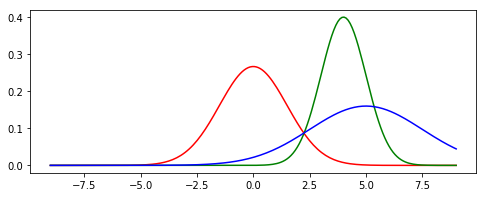

In [19]:
f, ax = plt.subplots(1, 1, sharey=True, sharex=True, figsize = (8,3))
mu_w = 0
sigma_w = 1.5 
X_updated = 4
P_updated = 1

x, posterior = plot_gaussian(mu = mu_w, sig = sigma_w, N = 6, ax = ax, color = 'r')

W = plot_gaussian(mu = X_updated, sig = P_updated, N = 6, ax = ax, x=x, color = 'g')

mu_p, sig_p = predict(sigma_w, X_updated, P_updated, a = 1, b = 1, U = 1)

W = plot_gaussian(mu = mu_p, sig = sig_p, N = 6, ax = ax, x=x, color = 'b')
plt.show()

La roja es el error del proceso (walking error), la verde es la posición del robot con su errory la azul es la predicción de la proxima posición

Nota que la azul "avanza" debido a que b y U son 1 (notar que la roja esta centrada en cero)

# Ejemplo de robot caminando con dominio continuo 
Acomodamos el modelo a los ejemplos de las notebooks anteriores pero ahora continuo

$X_{k+1} = X_k + Vel + W_k$

$Z_k = X_k + V_k$

$Vel$ is the velocity in units per iterations. It is $bU$ in the formal definition

In [20]:
from kalman1d import Kalman1D

## Ejemplo 1: Ruido de observación mucho mayor que el de caminata
Velocidad del robot $bU = 1$

In [21]:
kalman = Kalman1D(sigma_v=10, sigma_w=0.1, X_0=0, P_0=50, U=1, b=1)
print(kalman)

Model parameters:
Observation Noise Variance: 10
Process Noise Variance: 0.1
Initial guess: 0
Initial uncertainty: 50
h=1, a=1, b=1, U=1


### Modelo generativo ideal

Con fines demostrativos generamos muestras ideales. Sin ruido al caminar y sin ruido al observar
Pero ahora el sensor real del robot tiene una varianza de 10 y el ruido del proceso tiene una varianza de 0.1

Both measurements and ground truth are equal:
measurements: [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]
ground truth: [0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]


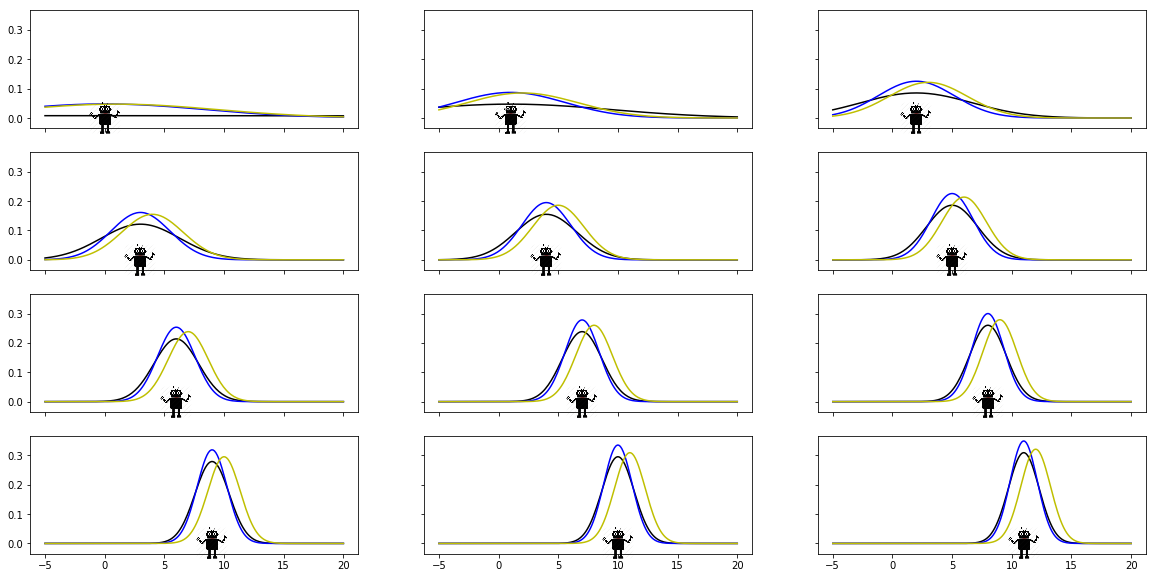

In [22]:
measurements, real_positions = kalman.generate_ideal_samples(1000)
print('Both measurements and ground truth are equal:')
print('measurements:',measurements[:10])
print('ground truth:',real_positions[:10])

# Lets filter and plot the results
kalman.filter()
kalman.plot_kalman_filter_steps(x_limits=[-5,20], show_legends=False)

Verde: predicción de la proxima posición  
Rojo: Prior  
Azul: Update  

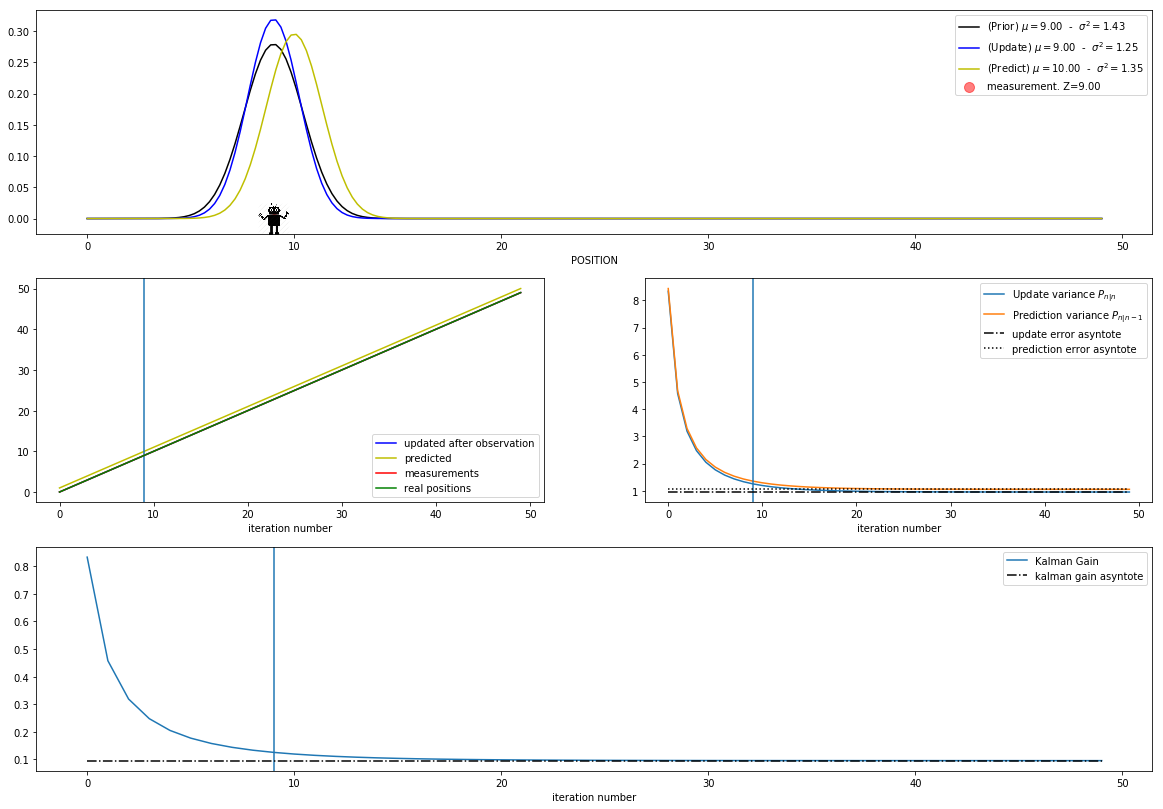

In [23]:
kalman.plot_interactive_kalman_filter(initial_slider_pos=10, max_number_of_steps=50)

### Caminata ideal, observación real

Model parameters:
Observation Noise Variance: 10
Process Noise Variance: 1
Initial guess: 0
Initial uncertainty: 50
h=1, a=1, b=1, U=1
Both measurements and ground truth are equal:
measurements: [-0.3150373282362568, -7.970443214482929, -1.4287353443815367, -8.516520846480052, 6.049680726752518, 9.9710822867858, -4.5502713888759985, 8.112105349799997, 9.213652656134878, 6.184034575880988]
ground truth: [0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]


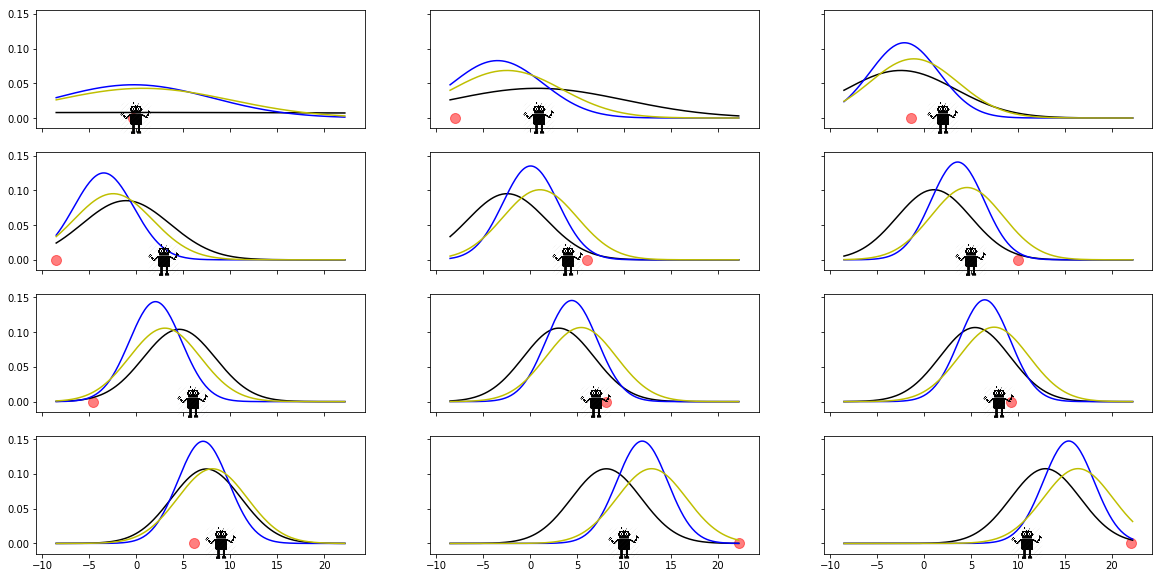

In [24]:
kalman_1 = Kalman1D(sigma_v=10, sigma_w=1, X_0=0, P_0=50, U=1, b=1)
print(kalman_1)

measurements, real_positions = kalman_1.generate_ideal_walking_samples(1000)
print('Both measurements and ground truth are equal:')
print('measurements:',measurements[:10])
print('ground truth:',real_positions[:10])

# Lets filter and plot the results
kalman_1.filter()
kalman_1.plot_kalman_filter_steps(show_legends=False)

Verde: predicción de la proxima posición  
Rojo: Prior  
Azul: Update  
Rojo: medición Z

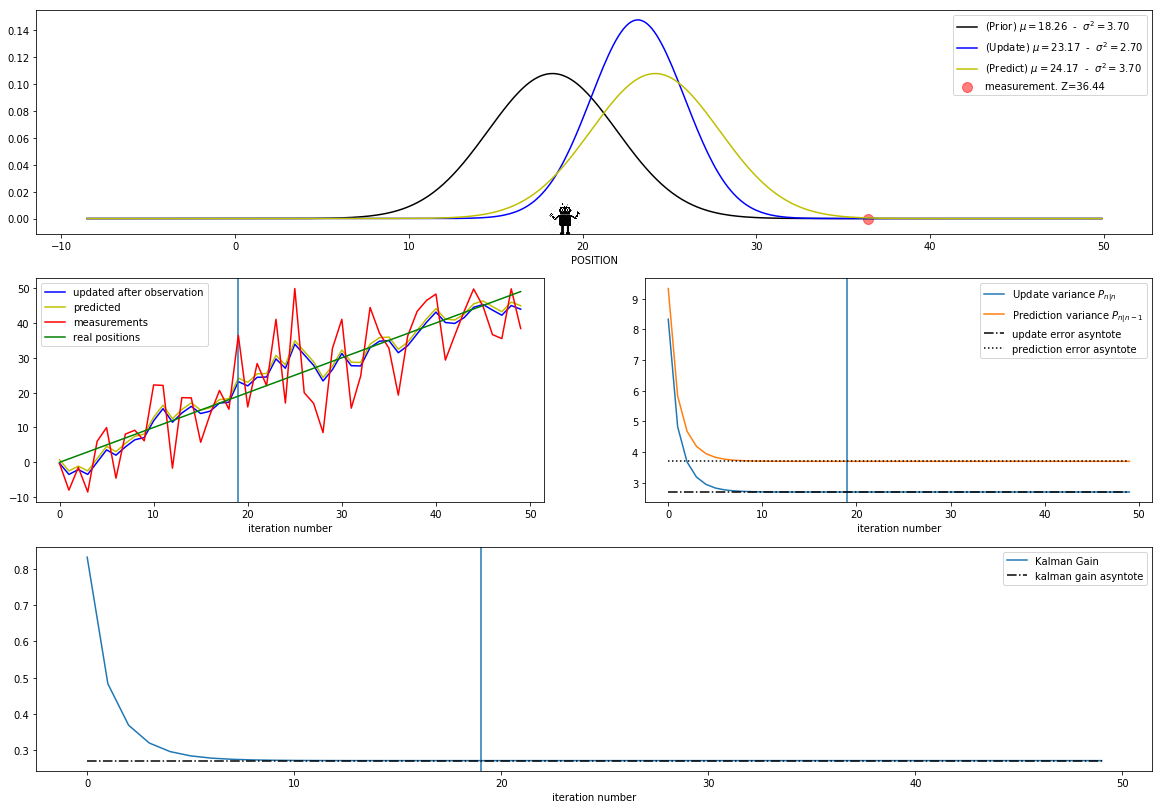

In [26]:
kalman_1.plot_interactive_kalman_filter(initial_slider_pos=20, max_number_of_steps=50, points = 400)

### Caminata y observaciones reales en el modelo generativo

Both measurements and ground truth are equal:
measurements: [-3.8081980884139464, 15.628302692943512, 13.360972503378608, -3.0141658893323533, 11.404779651850841, 1.285686605631171, -5.009637487939482, 9.744866871834235, 11.353159870471892, 12.291100559548516]
ground truth: [0, 1.01617315097786, 1.9863278744016344, 2.992639196771441, 3.8772253827266723, 4.850375357073613, 5.873334855413086, 6.838558598544373, 7.7605955888176705, 8.778624320958588]


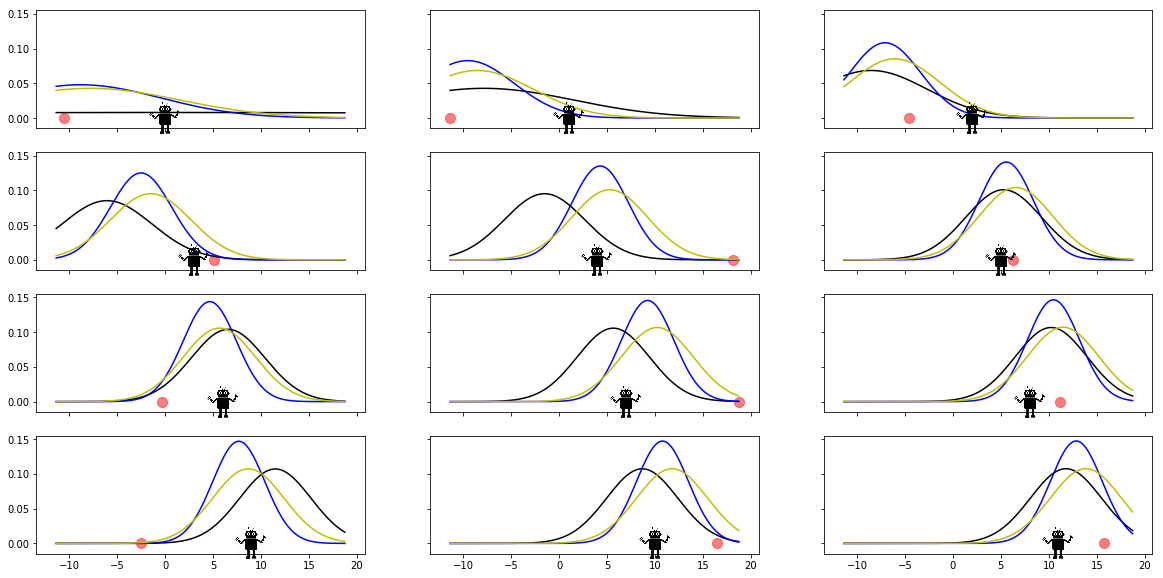

In [26]:
measurements, real_positions = kalman.generate_model_samples(1000)
print('Both measurements and ground truth are equal:')
print('measurements:',measurements[:10])
print('ground truth:',real_positions[:10])

# Lets filter and plot the results
kalman_1.filter()
kalman_1.plot_kalman_filter_steps(show_legends=False)

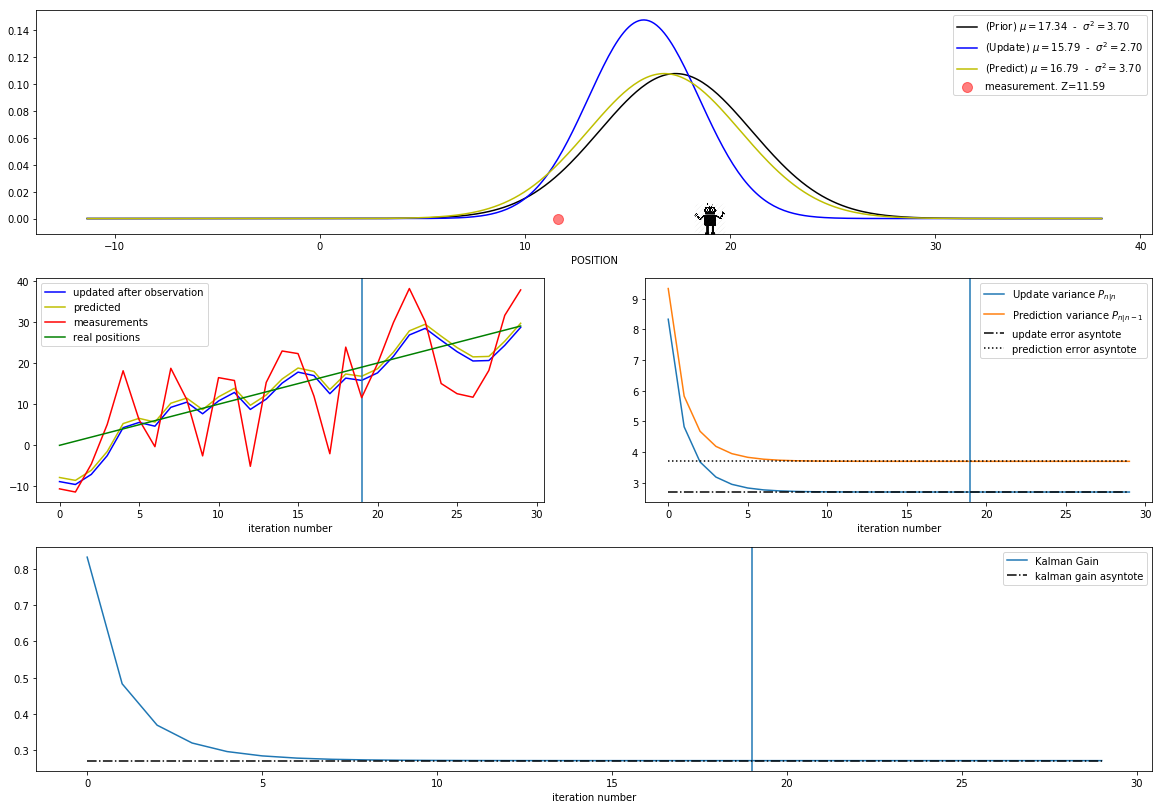

In [27]:
kalman_1.plot_interactive_kalman_filter(initial_slider_pos=20, max_number_of_steps=30, points = 400)

## Ejemplo 2: Robot se queda siempre en la misma posición
Se queda en la posición pero con ruido (se mueve "levemente")

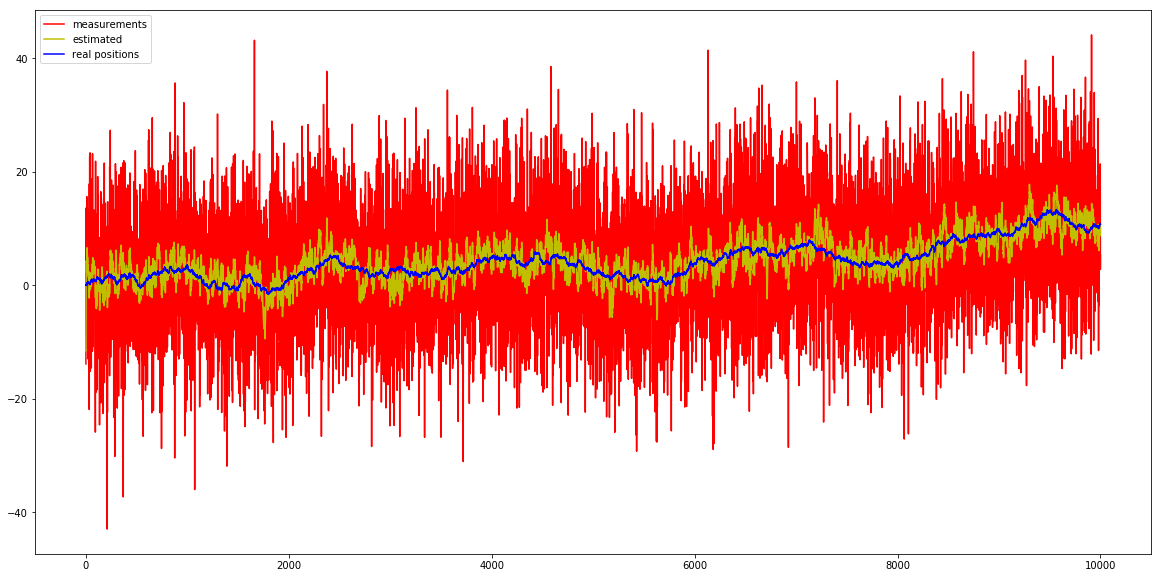

<function __main__.plot_kalman_result>

In [29]:
from ipywidgets import *
def plot_kalman_result(sigma_v=10, sigma_w=0.1):
    plt.figure(figsize=(20,10))
    kalman_2 = Kalman1D(sigma_v=sigma_v, sigma_w=sigma_w, X_0=0, P_0=50, U=0, b=1)
    _ = kalman_2.generate_model_samples(10000)
    kalman_2.filter()
    kalman_2.plot_kalman_filter_results()
    #ax = plt.gca()
    #print(ax.get_ylim())
    plt.show()
interact(plot_kalman_result, 
         sigma_v = widgets.IntSlider(min=0, max=40,step=1, value=10,continuous_update=False),
         sigma_w = widgets.FloatSlider(min=0, max=2,step=0.1, value=0.1,continuous_update=False)
        )

# Limitaciones del filtro de Kalman de 1D

## Error en la definición del modelo

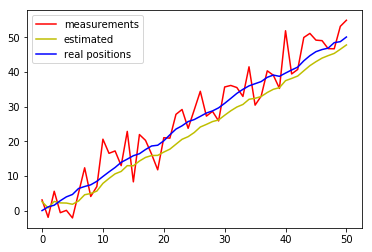

In [33]:
kalman_generative_model = Kalman1D(sigma_v=5, sigma_w=0.5, X_0=0, P_0=50, U=1, b=1)
samples = kalman_generative_model.generate_model_samples(50)

kalman_filter_model = Kalman1D(sigma_v=10, sigma_w=0.1, X_0=0, P_0=50, U=0.5, b=1)
kalman_filter_model.filter(*samples)
kalman_filter_model.plot_kalman_filter_results()

Que pasa si realmente la velocidad que supuse es incorrecta?